# RFDiffusion Breakdown Part II
diffusion part 
general procedue
1. take X0 ~ P(x0) 
2. sample t ~(0, T)
3. sample noise ~ Gaussian distribution N(0, I)
4. use scheduler to generate beta values, alpha values and alpha bar values (fixed not trainable)
5. get xt = sqrt(alpah_t_bar)X0 + sqrt(1-alpha_t_bar)*noise
6. for training we build a model taking xt and t as input to predict noise : minimize ||noise -model(xt, t)||

In [3]:
# Look at schduler in RFDiffusion (a linear one)
import torch
def get_beta_schedule(T, b0, bT, schedule_type, schedule_params={}, inference=False):
    """
    Given a noise schedule type, create the beta schedule
    """
    assert schedule_type in ["linear"]

    # Adjust b0 and bT if T is not 200
    # This is a good approximation, with the beta correction below, unless T is very small
    assert T >= 15, "With discrete time and T < 15, the schedule is badly approximated"
    b0 *= 200 / T
    bT *= 200 / T

    # linear noise schedule
    if schedule_type == "linear":
        schedule = torch.linspace(b0, bT, T)

    else:
        raise NotImplementedError(f"Schedule of type {schedule_type} not implemented.")

    # get alphabar_t for convenience
    alpha_schedule = 1 - schedule
    alphabar_t_schedule = torch.cumprod(alpha_schedule, dim=0)

    if inference:
        print(
            f"With this beta schedule ({schedule_type} schedule, beta_0 = {round(b0, 3)}, beta_T = {round(bT,3)}), alpha_bar_T = {alphabar_t_schedule[-1]}"
        )

    return schedule, alpha_schedule, alphabar_t_schedule

# an simple exmple 15 is used for T for visualization purpose
schedule, alpha_schedule, alphabar_t_schedule =get_beta_schedule(15, 0, 0.6, schedule_type="linear")
print(schedule)  # beta
print(alpha_schedule) # 1-beta
print(alphabar_t_schedule) # cumulative multiplication of (1-beta)

tensor([0.0000, 0.5714, 1.1429, 1.7143, 2.2857, 2.8571, 3.4286, 4.0000, 4.5714,
        5.1429, 5.7143, 6.2857, 6.8571, 7.4286, 8.0000])
tensor([ 1.0000,  0.4286, -0.1429, -0.7143, -1.2857, -1.8571, -2.4286, -3.0000,
        -3.5714, -4.1429, -4.7143, -5.2857, -5.8571, -6.4286, -7.0000])
tensor([ 1.0000e+00,  4.2857e-01, -6.1225e-02,  4.3732e-02, -5.6227e-02,
         1.0442e-01, -2.5359e-01,  7.6078e-01, -2.7171e+00,  1.1256e+01,
        -5.3066e+01,  2.8049e+02, -1.6429e+03,  1.0561e+04, -7.3930e+04])


## ADDING NOISE TO CA (translaiton noise)

In [5]:
# add noise step
# in RFDiffusion, instead of calculating xt = sqrt(alpah_t_bar)X0 + sqrt(1-alpha_t_bar)*noise, 
#it calcualte recursively for all t value based on xt = xt-1*sqrt(1-beta_t)+ noise* sqrt(beata_t)
# RUN ONE TIME
def apply_kernel(self, x, t, diffusion_mask=None, var_scale=1):
        """
        Applies a noising kernel to the points in x

        Parameters:
            x (torch.tensor, required): (N,3,3) set of backbone coordinates

            t (int, required): Which timestep

            noise_scale (float, required): scale for noise
        """
        t_idx = t - 1  # bring from 1-indexed to 0-indexed

        assert len(x.shape) == 3
        L, _, _ = x.shape

        # c-alpha crds
        ca_xyz = x[:, 1, :]

        b_t = schedule[t_idx]

        # get the noise at timestep t
        mean = torch.sqrt(1 - b_t) * ca_xyz
        var = torch.ones(L, 3) * (b_t) * var_scale

        sampled_crds = torch.normal(mean, torch.sqrt(var)) # equal to xt = xt-1*sqrt(1-beta_t)+ noise* sqrt(beata_t)
        delta = sampled_crds - ca_xyz # calcualte added noise [B,L,3]

        if not diffusion_mask is None:
            delta[diffusion_mask, ...] = 0

        out_crds = x + delta[:, None, :] # apply to all atoms N CA O

        return out_crds, delta

# RUN RECURSIVELY
def apply_kernel_recursive(self, xyz, diffusion_mask=None, var_scale=1):
    """
    Repeatedly apply self.apply_kernel T times and return all crds
    """
    bb_stack = [] # save a series of crds with noises
    T_stack = [] # save noise

    cur_xyz = torch.clone(xyz)

    for t in range(1, self.T + 1):
        cur_xyz, cur_T = self.apply_kernel(
            cur_xyz, t, var_scale=var_scale, diffusion_mask=diffusion_mask
        )
        bb_stack.append(cur_xyz)
        T_stack.append(cur_T)

    return torch.stack(bb_stack).transpose(0, 1), torch.stack(T_stack).transpose(
        0, 1
    )


## Add Noise to orientation (torsion noise)

In [9]:
from scipy.spatial.transform import Rotation as R
import numpy as np

# different ways to represent rotation and covnertion
rotation_vector = np.array([0.1, 0.2, 0.3])
quaternion_scipy = R.from_rotvec(rotation_vector).as_quat()
rmatrix_scipy = R.from_rotvec(rotation_vector).as_matrix()
euler_scipy = R.from_rotvec(rotation_vector).as_euler('zyz')

print("Quaternion (scipy):", quaternion_scipy)
print("Rotation matrix (scipy):", rmatrix_scipy)
print("Euler angle(scipy):", euler_scipy)

Quaternion (scipy): [0.04970884 0.09941769 0.14912653 0.98255098]
Rotation matrix (scipy): [[ 0.9357548  -0.28316496  0.21019171]
 [ 0.30293271  0.95058062 -0.06803132]
 [-0.18054008  0.12733457  0.97529031]]
Euler angle(scipy): [ 0.6142729   0.22276503 -0.31302232]


In [ ]:
# in RFDiffusion, rotation vector is used and map to so(3) and SO(3)
# READ this paper: https://openreview.net/pdf?id=BY88eBbkpe5


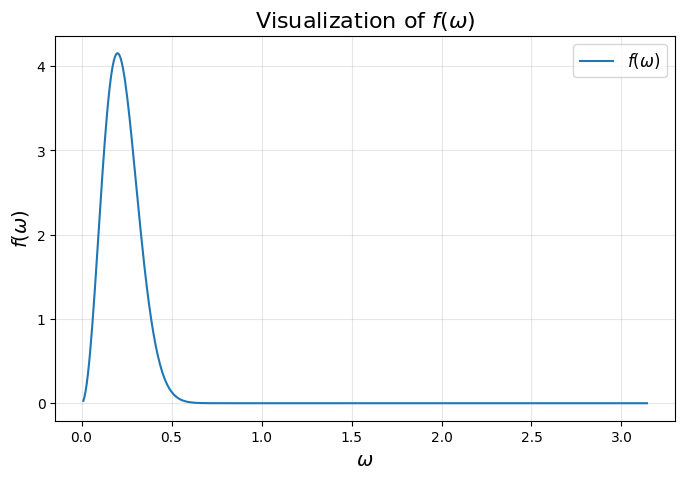

In [ ]:
# a visualization of distribution function of w (rotation angle of a rotaion axis) in istropic guassian distribution
# eq 5 in above paper
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(omega, epsilon=0.1, l_max=50):
    result = (1 - np.cos(omega)) / np.pi
    summation = 0
    for l in range(l_max + 1):
        term = (2 * l + 1) * np.exp(-l * (l + 1) * epsilon**2)
        term *= np.sin((l + 0.5) * omega) / np.sin(omega / 2)
        summation += term
    return result * summation

# Range of omega values
omega_values = np.linspace(0.01, np.pi, 500)  # Avoid division by zero at omega=0
epsilon = 0.1  # Small parameter
l_max = 50     # Truncation limit for the summation

# Compute f(omega) for the range of omega values
f_values = [f(omega, epsilon, l_max) for omega in omega_values]

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(omega_values, f_values, label=r"$f(\omega)$")
plt.xlabel(r"$\omega$", fontsize=14)
plt.ylabel(r"$f(\omega)$", fontsize=14)
plt.title("Visualization of $f(\omega)$", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [13]:
# in RFDiffusion an approximation is used
L_default = 2000
def f_igso3(omega, t, L=L_default):
    """Truncated sum of IGSO(3) distribution.

    This function approximates the power series in equation 5 of
    "DENOISING DIFFUSION PROBABILISTIC MODELS ON SO(3) FOR ROTATIONAL
    ALIGNMENT"
    Leach et al. 2022

    This expression diverges from the expression in Leach in that here, sigma =
    sqrt(2) * eps, if eps_leach were the scale parameter of the IGSO(3).

    With this reparameterization, IGSO(3) agrees with the Brownian motion on
    SO(3) with t=sigma^2 when defined for the canonical inner product on SO3,
    <u, v>_SO3 = Trace(u v^T)/2

    Args:
        omega: i.e. the angle of rotation associated with rotation matrix
        t: variance parameter of IGSO(3), maps onto time in Brownian motion
        L: Truncation level
    """
    ls = torch.arange(L)[None]  # of shape [1, L]
    return ((2*ls + 1) * torch.exp(-ls*(ls+1)*t/2) *
             torch.sin(omega[:, None]*(ls+1/2)) / torch.sin(omega[:, None]/2)).sum(dim=-1)

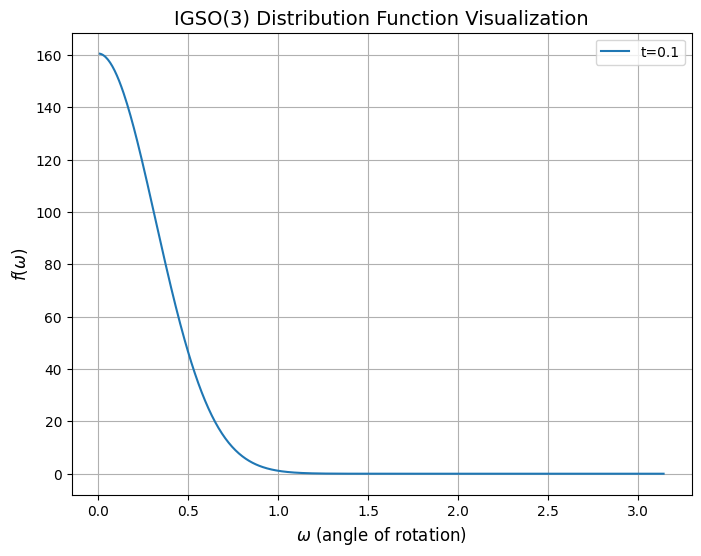

In [17]:
# visualization
omega = np.linspace(0.01, np.pi, 500)  # Avoid zero to prevent division by zero
t = 0.1  # Example variance parameter

# Define the function f_igso3 as described
def f_igso3(omega, t, L=2000):
    ls = torch.arange(L)[None]  # of shape [1, L]
    omega = torch.tensor(omega, dtype=torch.float32)
    return ((2 * ls + 1) * torch.exp(-ls * (ls + 1) * t / 2) *
            torch.sin(omega[:, None] * (ls + 1 / 2)) / torch.sin(omega[:, None] / 2)).sum(dim=-1).numpy()


# Evaluate the function
f_values = f_igso3(omega, t)

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(omega, f_values, label=f"t={t}")
plt.xlabel(r'$\omega$ (angle of rotation)', fontsize=12)
plt.ylabel(r'$f(\omega)$', fontsize=12)
plt.title("IGSO(3) Distribution Function Visualization", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [4]:
# convertion of Lie algebra so3 and Lie group SO3
# rotation vector (R^3)<-> so3 <-> rotation matrix SO3 
# so3 is flat and linear space, therefore, we operate on so3 first then project back to SO3 or R3

# convertion between rotation vector to so3
import torch
def hat(v):
    hat_v = torch.zeros([v.shape[0], 3, 3])
    hat_v[:, 0, 1], hat_v[:, 0, 2], hat_v[:, 1, 2] = -v[:, 2], v[:, 1], -v[:, 0]
    return hat_v + -hat_v.transpose(2, 1)
# v is a rotation vector ||v|| is ration angle v/||v|| is rotation axis
v=[[0.1, 0.2, 0.3]]
hat(torch.tensor(v))

tensor([[[ 0.0000, -0.3000,  0.2000],
         [ 0.3000,  0.0000, -0.1000],
         [-0.2000,  0.1000,  0.0000]]])

In [5]:
from scipy.spatial.transform import Rotation
# Logarithmic map from SO(3) to R^3 (i.e. rotation vector)
def Log(R): return torch.tensor(Rotation.from_matrix(R.numpy()).as_rotvec())

# logarithmic map from SO(3) to so(3), this is the matrix logarithm
def log(R): return hat(Log(R))


In [11]:
# testing 

# first generate a rotation matrix
import numpy as np

def generate_rotation_matrix():
    # Generate a random unit vector (axis of rotation)
    axis = np.random.randn(3)
    axis /= np.linalg.norm(axis)
    
    # Generate a random rotation angle in radians
    angle = np.random.uniform(0, 2 * np.pi)
    
    # Compute the components of the rotation matrix using the axis-angle formula
    cos_theta = np.cos(angle)
    sin_theta = np.sin(angle)
    ux, uy, uz = axis
    
    # Construct the rotation matrix
    rotation_matrix = np.array([
        [cos_theta + ux**2 * (1 - cos_theta),       ux * uy * (1 - cos_theta) - uz * sin_theta, ux * uz * (1 - cos_theta) + uy * sin_theta],
        [uy * ux * (1 - cos_theta) + uz * sin_theta, cos_theta + uy**2 * (1 - cos_theta),       uy * uz * (1 - cos_theta) - ux * sin_theta],
        [uz * ux * (1 - cos_theta) - uy * sin_theta, uz * uy * (1 - cos_theta) + ux * sin_theta, cos_theta + uz**2 * (1 - cos_theta)]
    ])
    
    return torch.tensor([rotation_matrix])

# Generate a random rotation matrix
rotation_matrix = generate_rotation_matrix()
print("Rotation Matrix:")
print(rotation_matrix)

y1= log(rotation_matrix)
print([y1])


Rotation Matrix:
tensor([[[ 0.2378,  0.1969,  0.9512],
         [-0.4479,  0.8912, -0.0725],
         [-0.8619, -0.4088,  0.3001]]], dtype=torch.float64)
[tensor([[[ 0.0000,  0.4471,  1.2573],
         [-0.4471,  0.0000,  0.2332],
         [-1.2573, -0.2332,  0.0000]]])]


In [12]:
# map from vector space  to SO(3), this is the matrix
def Exp(A): return torch.tensor(Rotation.from_rotvec(A.numpy()).as_matrix())

# Angle of rotation SO(3) to R^+ (scaler the rotation angle ||v||)
def Omega(R): return np.linalg.norm(log(R), axis=[-2, -1])/np.sqrt(2.)


In [14]:
# PDF of omega in various form

# CDF of log_f
L_default=200
def d_logf_d_omega(omega, t, L=L_default):
    omega = torch.tensor(omega, requires_grad=True)
    log_f = torch.log(f_igso3(omega, t, L))
    return torch.autograd.grad(log_f.sum(), omega)[0].numpy()

# IGSO3 density with respect to the volume form on SO(3)
def igso3_density(Rt, t, L=L_default):
    return f_igso3(torch.tensor(Omega(Rt)), t, L).numpy()
# IGSO3 density (pdf) in omega (eq 5)
def igso3_density_angle(omega, t, L=L_default): 
    return f_igso3(torch.tensor(omega), t, L).numpy()*(1-np.cos(omega))/np.pi
